In [1]:
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distr

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 8)

torch.__version__

'0.3.0.post4'

In [2]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [ ]:
def cuda_wrapper(tensor, use_cuda=USE_CUDA):
    if use_cuda:
        return tensor.cuda()
    else:
        return tensor

In [3]:
from torchvision import datasets, transforms

kwargs = {}
batch_size = 24
test_batch_size = 24

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './data', train=True, download=False,
        transform=transforms.Compose(
            #[transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            [transforms.ToTensor()]
        )
    ), batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './data', train=False, 
        transform=transforms.Compose(
            #[transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            [transforms.ToTensor()]
        )
    ), batch_size=test_batch_size, shuffle=True, **kwargs
)


In [4]:
class SigmoidBeliefNetwork(nn.Module):
    def __init__(self, input_dim, output_dim=None, num_blocks=1, hidden_dim=200, nonlinear_blocks=False):
        super(SigmoidBeliefNetwork, self).__init__()
        
        if output_dim is None:
            output_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        
        layer_input_dim = input_dim
        layer_output_dim = hidden_dim
            
        self.dense_layers = nn.ModuleList()
        self.nonlinearities = nn.ModuleList()
        
        for _ in range(num_blocks):
            self.dense_layers.append(nn.ModuleList())
            self.nonlinearities.append(nn.ModuleList())
            if nonlinear_blocks:
                for _ in range(3):
                    self.dense_layers[-1].append(nn.Linear(layer_input_dim, layer_output_dim))
                    layer_input_dim = layer_output_dim
                    layer_output_dim = hidden_dim
                for _ in range(2):
                    self.nonlinearities[-1].append(nn.Tanh())
                self.nonlinearities[-1].append(nn.Sigmoid())
            else:
                self.dense_layers[-1].append(nn.Linear(layer_input_dim, layer_output_dim))
                layer_input_dim = layer_output_dim
                layer_output_dim = hidden_dim
                self.nonlinearities[-1].append(nn.Sigmoid())
                    
        self.output_layer = nn.Linear(layer_input_dim, output_dim)
        
        self.eps = 1.0e-6
        
    def _soft_forward(self, X, sigmoid_temp, start_block_idx):
        soft_output = X
        for i in range(start_block_idx, self.num_blocks):
            for dense_layer, nonlinearity in zip(self.dense_layers[i], self.nonlinearities[i]):
                soft_output = nonlinearity(dense_layer(soft_output))
            prob = torch.clamp(soft_output, min=self.eps, max=1.-self.eps)
            
            u = autograd.Variable(
                cuda_wrapper(torch.Tensor(prob.size()).uniform_()), requires_grad=False
            )

            z = torch.log(prob * u + self.eps) - torch.log((1 - prob) * (1 - u) + self.eps)
            soft_output = torch.sigmoid(z / sigmoid_temp)
            
        return self.output_layer(soft_output)
            
    def forward(self, X, sigmoid_temp=1.0):
        self.sample_log_probs = []
        final_soft_outputs = []
        final_cond_soft_outputs = []

        hard_output = X
        for i in range(self.num_blocks):
            for dense_layer, nonlinearity in zip(self.dense_layers[i], self.nonlinearities[i]):
                hard_output = nonlinearity(dense_layer(hard_output))
            prob = torch.clamp(hard_output, min=self.eps, max=1.-self.eps)
            
            u = autograd.Variable(
                cuda_wrapper(torch.Tensor(prob.size()).uniform_()), requires_grad=False
            )
            v = autograd.Variable(
                cuda_wrapper(torch.Tensor(prob.size()).uniform_()), requires_grad=False
            )

            z = torch.log(prob * u + self.eps) - torch.log((1 - prob) * (1 - u) + self.eps)
            b = (z > 0)
            v = v * (1 - prob) * (1 - b.float()) + (v * prob + (1 - prob)) * b.float() 
            z_cond = torch.log(prob * v + self.eps) - torch.log((1 - prob) * (1 - v) + self.eps)

            self.sample_log_probs.append(distr.Bernoulli(prob).log_prob(b))
            
            hard_output = b.float()
            soft_output = torch.sigmoid(z / sigmoid_temp)
            cond_soft_output = torch.sigmoid(z_cond / sigmoid_temp)
            
            final_soft_outputs.append(self._soft_forward(soft_output, sigmoid_temp, start_block_idx=i+1))
            final_cond_soft_outputs.append(self._soft_forward(cond_soft_output, sigmoid_temp, start_block_idx=i+1))
        
        final_hard_output = self.output_layer(hard_output)
        return final_hard_output, final_soft_outputs, final_cond_soft_outputs
    

In [5]:
input_dim = train_loader.dataset.train_data.size()
input_dim = input_dim[1] * input_dim[2] // 2
input_dim

392

In [ ]:
from time import time

num_steps = 500 * 1000
num_epochs = num_steps * batch_size // train_loader.dataset.train_data.size(0)
#num_epochs = 10
num_blocks = 1

#opt_modes = ['last_epoch_reward_baseline', 'no_baseline', 'reparam_1.0', 'reparam_0.1', 'reparam_10.']
opt_modes = ['rebar_0.1', 'reparam_0.1', 'no_baseline']
train_losses = {}

learning_rate = 0.0001
eta_learning_rate = 1e-11
eta_start = 1.0

logsigmoid = nn.LogSigmoid()

for opt_mode in opt_modes:
    print()
    print(opt_mode)
    train_losses[opt_mode] = []
    model = cuda_wrapper(SigmoidBeliefNetwork(input_dim, num_blocks=num_blocks, hidden_dim=200, nonlinear_blocks=True))
    if num_blocks > 0:
        num_layers = len(model.dense_layers[0])
    else:
        num_layers = 0
        
    eta = cuda_wrapper(torch.Tensor(num_blocks, num_layers, 2).fill_(eta_start))
    variance_grad_smoothed = cuda_wrapper(torch.Tensor(num_blocks, num_layers, 2).zero_())
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99999))
    
    alpha = 0.999
    
    for epoch in range(num_epochs):
        start_time = time()
        print('Epoch {} of {}'.format(epoch+1, num_epochs))
        
        torch.manual_seed(42)
        
        if opt_mode.startswith('reparam') or opt_mode.startswith('rebar'):
            sigmoid_temp = float(opt_mode.split('_')[1])
        else:
            sigmoid_temp = 1.0
        
        loader = train_loader
        num_samples = train_loader.dataset.train_data.size(0)
        
        cum_losses = 0
        for batch_idx, (data, target) in enumerate(loader):
            top, bottom = torch.chunk(
                (data.view(data.size(0), -1) > 0.5).float(), 2, dim=1
            )
            top, bottom = autograd.Variable(cuda_wrapper(top), requires_grad=False), \
                          autograd.Variable(cuda_wrapper(bottom), requires_grad=False)
            hard_bottom_logit, soft_bottom_logits, soft_cond_bottom_logits = model(top, sigmoid_temp)

            hard_samplewise_loss = -torch.sum(
                logsigmoid(hard_bottom_logit) * bottom + logsigmoid(-hard_bottom_logit) * (1 - bottom), dim=1
            )
            hard_loss = torch.sum(hard_samplewise_loss)

            soft_samplewise_losses = []
            soft_cond_samplewise_losses = []
            soft_losses = []
            soft_cond_losses = []
            for i in range(num_blocks):
                soft_samplewise_losses.append(
                    -torch.sum(
                        logsigmoid(soft_bottom_logits[i]) * bottom +\
                        logsigmoid(-soft_bottom_logits[i]) * (1 - bottom), dim=1
                    )
                )
                soft_losses.append(torch.sum(soft_samplewise_losses[-1]))
                
                soft_cond_samplewise_losses.append(
                    -torch.sum
                    (
                        logsigmoid(soft_cond_bottom_logits[i]) * bottom +\
                        logsigmoid(-soft_cond_bottom_logits[i]) * (1 - bottom), dim=1
                    )
                )
                soft_cond_losses.append(torch.sum(soft_cond_samplewise_losses[-1]))
            
            cum_losses += hard_loss.data.mean()

            optimizer.zero_grad()
            
            if opt_mode in ['no_baseline', 'last_epoch_reward_baseline']:
                cost = torch.stack([hard_samplewise_loss.detach()] * model.hidden_dim, dim=1)
                if opt_mode == 'no_baseline':
                    baseline = 0
                elif opt_mode == 'last_epoch_reward_baseline':
                    baseline = autograd.Variable(train_losses[opt_mode][-1], requires_grad=False) if epoch > 0 else 0
                for sample_log_prob in model.sample_log_probs:
                    hard_loss += torch.sum(sample_log_prob * (cost - baseline))
                hard_loss.backward()
                optimizer.step()
        
            elif opt_mode.startswith('reparam'):
                soft_losses[0].backward()
                optimizer.step()
        
            elif opt_mode.startswith('rebar'):
                for i in range(num_blocks):
                    cost = torch.stack(
                        [-soft_cond_samplewise_losses[i].detach()] * model.hidden_dim, dim=1
                    )
                    loss_eta_linear_coef = soft_losses[i] - soft_cond_losses[i]
                    loss_eta_linear_coef += torch.sum(model.sample_log_probs[i] * cost)
                    loss_eta_linear_coef.backward(retain_graph=True)
                    for j in range(i+1, num_blocks):
                        for dense_layer in model.dense_layers[j]:
                            dense_layer.zero_grad()
                
                loss_eta_linear_coef_grads = []
                for i in range(num_blocks):
                    loss_eta_linear_coef_grads.append([])
                    for dense_layer in model.dense_layers[i]:
                        loss_eta_linear_coef_grads[-1].append([])
                        for param in dense_layer.parameters():
                            loss_eta_linear_coef_grads[-1][-1].append(param.grad.data.clone())
                
                for i in range(num_blocks):
                    for j, dense_layer in enumerate(model.dense_layers[i]):
                        for k, param in enumerate(dense_layer.parameters()):
                            param.grad.data *= eta[i, j, k]

                cost_additional = torch.stack(
                    [hard_samplewise_loss.detach()] * model.hidden_dim, dim=1
                )
                loss_additional = 0
                for sample_log_prob in model.sample_log_probs:
                    loss_additional += torch.sum(sample_log_prob * cost_additional)
                loss_additional.backward(retain_graph=True)
                
                loss_grads = []
                for i in range(num_blocks):
                    loss_grads.append([])
                    for dense_layer in model.dense_layers[i]:
                        loss_grads[-1].append([])
                        for param in dense_layer.parameters():
                            loss_grads[-1][-1].append(param.grad.data.clone())
                
                model.output_layer.zero_grad()
                hard_loss.backward()
                optimizer.step()
                
                variance_grad = cuda_wrapper(torch.Tensor(num_blocks, num_layers, 2).zero_())
                for i in range(num_blocks):
                    for j in range(num_layers):
                        for k in range(2):
                            variance_grad[i, j, k] = torch.sum(
                                loss_grads[i][j][k] * loss_eta_linear_coef_grads[i][j][k]
                            ) * 2
                variance_grad_smoothed = alpha * variance_grad_smoothed + (1 - alpha) * variance_grad
                eta = torch.clamp(eta - variance_grad_smoothed * eta_learning_rate, min=0.)
                
        mean_loss = cum_losses / num_samples
        print("loss: {:.2f}".format(mean_loss))
        train_losses[opt_mode].append(mean_loss)
        
        for i in range(num_blocks):
            print('block {}:'.format(i + 1))
            for j in range(num_layers):
                print('layer {}:'.format(j + 1))
                print('eta_w: {:.4f}, eta_b: {:.4f}'.format(eta[i, j, 0], eta[i, j, 1]))
        
        print('elapsed time: {:.1f}s'.format(time() - start_time))
        print()


rebar_0.1
Epoch 1 of 200
loss: 115.72
block 1:
layer 1:
eta_w: 1.0009, eta_b: 1.0000
layer 2:
eta_w: 1.0008, eta_b: 1.0000
layer 3:
eta_w: 0.9994, eta_b: 1.0002
elapsed time: 34.9s

Epoch 2 of 200
loss: 109.08
block 1:
layer 1:
eta_w: 1.0009, eta_b: 1.0000
layer 2:
eta_w: 1.0008, eta_b: 1.0000
layer 3:
eta_w: 1.0002, eta_b: 1.0002
elapsed time: 34.6s

Epoch 3 of 200
loss: 109.02
block 1:
layer 1:
eta_w: 1.0009, eta_b: 1.0000
layer 2:
eta_w: 1.0008, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0002
elapsed time: 35.2s

Epoch 4 of 200
loss: 109.01
block 1:
layer 1:
eta_w: 1.0009, eta_b: 1.0000
layer 2:
eta_w: 1.0008, eta_b: 1.0000
layer 3:
eta_w: 0.9999, eta_b: 1.0002
elapsed time: 32.0s

Epoch 5 of 200
loss: 109.00
block 1:
layer 1:
eta_w: 1.0009, eta_b: 1.0000
layer 2:
eta_w: 1.0008, eta_b: 1.0000
layer 3:
eta_w: 0.9999, eta_b: 1.0002
elapsed time: 31.3s

Epoch 6 of 200
loss: 109.00
block 1:
layer 1:
eta_w: 1.0009, eta_b: 1.0000
layer 2:
eta_w: 1.0008, eta_b: 1.0000
layer 3:
eta_w: 

loss: 66.43
block 1:
layer 1:
eta_w: 1.0021, eta_b: 1.0022
layer 2:
eta_w: 1.0020, eta_b: 1.0021
layer 3:
eta_w: 1.0005, eta_b: 1.0002
elapsed time: 35.1s

Epoch 50 of 200
loss: 66.25
block 1:
layer 1:
eta_w: 1.0014, eta_b: 1.0021
layer 2:
eta_w: 1.0019, eta_b: 1.0021
layer 3:
eta_w: 1.0005, eta_b: 1.0002
elapsed time: 34.9s

Epoch 51 of 200
loss: 66.07
block 1:
layer 1:
eta_w: 1.0007, eta_b: 1.0019
layer 2:
eta_w: 1.0018, eta_b: 1.0021
layer 3:
eta_w: 1.0005, eta_b: 1.0002
elapsed time: 35.3s

Epoch 52 of 200
loss: 65.91
block 1:
layer 1:
eta_w: 1.0014, eta_b: 1.0017
layer 2:
eta_w: 1.0018, eta_b: 1.0021
layer 3:
eta_w: 1.0003, eta_b: 1.0002
elapsed time: 35.0s

Epoch 53 of 200
loss: 65.74
block 1:
layer 1:
eta_w: 1.0004, eta_b: 1.0015
layer 2:
eta_w: 1.0016, eta_b: 1.0021
layer 3:
eta_w: 1.0002, eta_b: 1.0002
elapsed time: 35.2s

Epoch 54 of 200
loss: 65.58
block 1:
layer 1:
eta_w: 1.0009, eta_b: 1.0013
layer 2:
eta_w: 1.0012, eta_b: 1.0021
layer 3:
eta_w: 1.0000, eta_b: 1.0002
elaps

loss: 61.83
block 1:
layer 1:
eta_w: 0.9958, eta_b: 0.9963
layer 2:
eta_w: 0.9978, eta_b: 0.9978
layer 3:
eta_w: 0.9977, eta_b: 1.0002
elapsed time: 34.7s

Epoch 98 of 200
loss: 61.78
block 1:
layer 1:
eta_w: 0.9951, eta_b: 0.9962
layer 2:
eta_w: 0.9976, eta_b: 0.9977
layer 3:
eta_w: 0.9975, eta_b: 1.0002
elapsed time: 34.7s

Epoch 99 of 200
loss: 61.73
block 1:
layer 1:
eta_w: 0.9951, eta_b: 0.9960
layer 2:
eta_w: 0.9976, eta_b: 0.9976
layer 3:
eta_w: 0.9976, eta_b: 1.0002
elapsed time: 35.0s

Epoch 100 of 200
loss: 61.68
block 1:
layer 1:
eta_w: 0.9953, eta_b: 0.9960
layer 2:
eta_w: 0.9979, eta_b: 0.9976
layer 3:
eta_w: 0.9975, eta_b: 1.0002
elapsed time: 34.5s

Epoch 101 of 200
loss: 61.63
block 1:
layer 1:
eta_w: 0.9944, eta_b: 0.9960
layer 2:
eta_w: 0.9974, eta_b: 0.9975
layer 3:
eta_w: 0.9974, eta_b: 1.0002
elapsed time: 35.1s

Epoch 102 of 200
loss: 61.57
block 1:
layer 1:
eta_w: 0.9954, eta_b: 0.9961
layer 2:
eta_w: 0.9971, eta_b: 0.9974
layer 3:
eta_w: 0.9974, eta_b: 1.0002
el

loss: 59.72
block 1:
layer 1:
eta_w: 0.9919, eta_b: 0.9925
layer 2:
eta_w: 0.9938, eta_b: 0.9945
layer 3:
eta_w: 0.9954, eta_b: 0.9973
elapsed time: 35.8s

Epoch 146 of 200
loss: 59.68
block 1:
layer 1:
eta_w: 0.9919, eta_b: 0.9924
layer 2:
eta_w: 0.9937, eta_b: 0.9944
layer 3:
eta_w: 0.9953, eta_b: 0.9973
elapsed time: 35.8s

Epoch 147 of 200
loss: 59.65
block 1:
layer 1:
eta_w: 0.9915, eta_b: 0.9925
layer 2:
eta_w: 0.9937, eta_b: 0.9944
layer 3:
eta_w: 0.9953, eta_b: 0.9972
elapsed time: 35.8s

Epoch 148 of 200
loss: 59.62
block 1:
layer 1:
eta_w: 0.9913, eta_b: 0.9925
layer 2:
eta_w: 0.9938, eta_b: 0.9943
layer 3:
eta_w: 0.9952, eta_b: 0.9972
elapsed time: 35.7s

Epoch 149 of 200
loss: 59.61
block 1:
layer 1:
eta_w: 0.9911, eta_b: 0.9926
layer 2:
eta_w: 0.9933, eta_b: 0.9943
layer 3:
eta_w: 0.9952, eta_b: 0.9972
elapsed time: 35.5s

Epoch 150 of 200
loss: 59.58
block 1:
layer 1:
eta_w: 0.9914, eta_b: 0.9926
layer 2:
eta_w: 0.9933, eta_b: 0.9943
layer 3:
eta_w: 0.9952, eta_b: 0.9971


loss: 58.28
block 1:
layer 1:
eta_w: 0.9893, eta_b: 0.9902
layer 2:
eta_w: 0.9920, eta_b: 0.9924
layer 3:
eta_w: 0.9935, eta_b: 0.9957
elapsed time: 35.8s

Epoch 194 of 200
loss: 58.26
block 1:
layer 1:
eta_w: 0.9894, eta_b: 0.9901
layer 2:
eta_w: 0.9916, eta_b: 0.9924
layer 3:
eta_w: 0.9935, eta_b: 0.9956
elapsed time: 35.2s

Epoch 195 of 200
loss: 58.24
block 1:
layer 1:
eta_w: 0.9895, eta_b: 0.9901
layer 2:
eta_w: 0.9912, eta_b: 0.9923
layer 3:
eta_w: 0.9934, eta_b: 0.9956
elapsed time: 35.2s

Epoch 196 of 200
loss: 58.23
block 1:
layer 1:
eta_w: 0.9890, eta_b: 0.9901
layer 2:
eta_w: 0.9915, eta_b: 0.9923
layer 3:
eta_w: 0.9936, eta_b: 0.9956
elapsed time: 35.1s

Epoch 197 of 200
loss: 58.20
block 1:
layer 1:
eta_w: 0.9888, eta_b: 0.9901
layer 2:
eta_w: 0.9915, eta_b: 0.9923
layer 3:
eta_w: 0.9934, eta_b: 0.9956
elapsed time: 35.3s

Epoch 198 of 200
loss: 58.19
block 1:
layer 1:
eta_w: 0.9893, eta_b: 0.9902
layer 2:
eta_w: 0.9916, eta_b: 0.9923
layer 3:
eta_w: 0.9935, eta_b: 0.9956


loss: 66.63
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 15.7s

Epoch 42 of 200
loss: 66.45
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 15.6s

Epoch 43 of 200
loss: 66.26
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 15.4s

Epoch 44 of 200
loss: 66.09
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 15.5s

Epoch 45 of 200
loss: 65.91
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 15.4s

Epoch 46 of 200
loss: 65.78
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elaps

loss: 61.87
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 15.4s

Epoch 90 of 200
loss: 61.80
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 15.1s

Epoch 91 of 200
loss: 61.74
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 15.0s

Epoch 92 of 200
loss: 61.68
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 15.0s

Epoch 93 of 200
loss: 61.63
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 15.1s

Epoch 94 of 200
loss: 61.58
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elaps

loss: 59.69
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 16.3s

Epoch 138 of 200
loss: 59.66
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 18.1s

Epoch 139 of 200
loss: 59.62
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 20.3s

Epoch 140 of 200
loss: 59.58
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 20.1s

Epoch 141 of 200
loss: 59.55
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 19.9s

Epoch 142 of 200
loss: 59.54
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000


loss: 89.92
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 21.1s

Epoch 34 of 200
loss: 89.82
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 21.3s

Epoch 35 of 200
loss: 89.76
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 21.4s

Epoch 36 of 200
loss: 89.70
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 20.8s

Epoch 37 of 200
loss: 89.62
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 21.0s

Epoch 38 of 200
loss: 89.57
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elaps

loss: 88.25
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 20.9s

Epoch 82 of 200
loss: 88.24
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 21.1s

Epoch 83 of 200
loss: 88.21
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 19.4s

Epoch 84 of 200
loss: 88.20
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 18.5s

Epoch 85 of 200
loss: 88.20
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 18.9s

Epoch 86 of 200
loss: 88.18
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elaps

loss: 88.01
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 19.1s

Epoch 130 of 200
loss: 88.01
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 18.8s

Epoch 131 of 200
loss: 88.01
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 19.3s

Epoch 132 of 200
loss: 88.03
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 19.1s

Epoch 133 of 200
loss: 88.01
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 19.1s

Epoch 134 of 200
loss: 88.01
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000


loss: 88.04
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 19.1s

Epoch 178 of 200
loss: 88.03
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 18.8s

Epoch 179 of 200
loss: 88.05
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 20.4s

Epoch 180 of 200
loss: 88.05
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 21.9s

Epoch 181 of 200
loss: 88.05
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000
elapsed time: 21.4s

Epoch 182 of 200
loss: 88.06
block 1:
layer 1:
eta_w: 1.0000, eta_b: 1.0000
layer 2:
eta_w: 1.0000, eta_b: 1.0000
layer 3:
eta_w: 1.0000, eta_b: 1.0000


## 1 layer non-linear model:

##### 200 epochs corresponds to 500 thousands steps

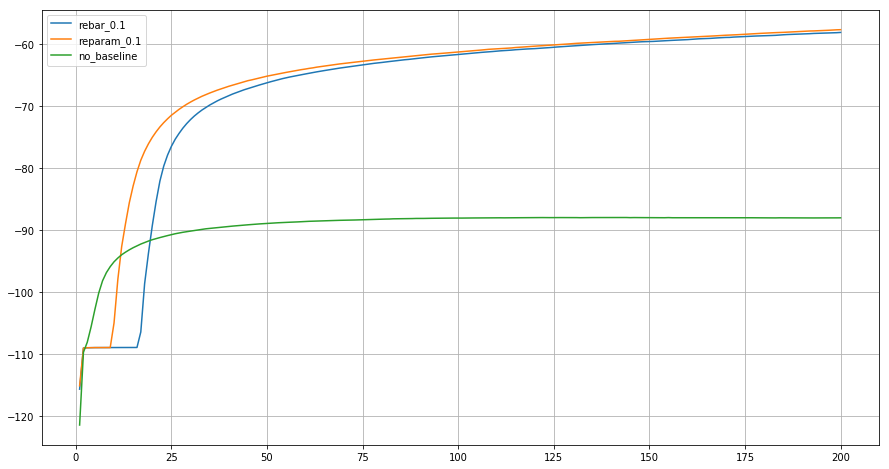

In [22]:
for opt_mode in opt_modes:
    plt.plot(range(1, num_epochs+1), -np.array(train_losses[opt_mode]))
plt.grid(True)
plt.legend(opt_modes)
#plt.plot(test_losses, 'k--')

In [23]:
print('Final performance:')
for opt_mode in opt_modes:
    print('{}: {:.2f}'.format(opt_mode, -train_losses[opt_mode][-1]))

Final performance:
rebar_0.1: -58.12
reparam_0.1: -57.67
no_baseline: -88.05


## 2 layers linear model:

##### 800 epochs corresponds to 2000 thousands steps

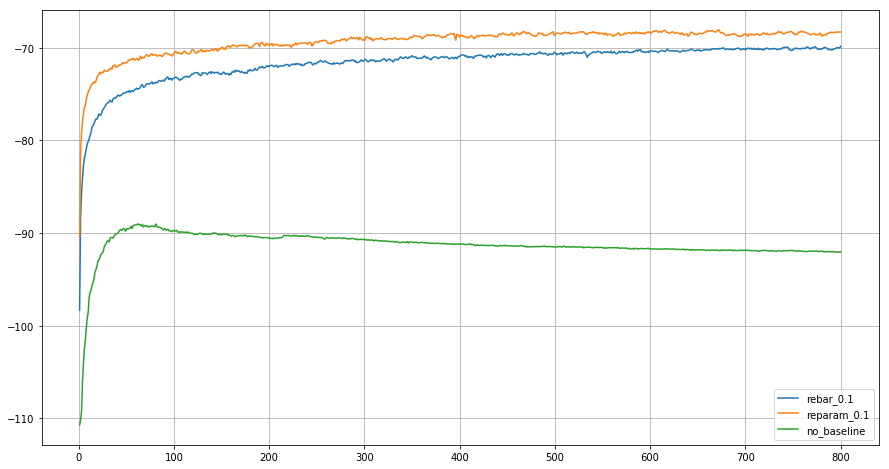

In [7]:
for opt_mode in opt_modes:
    plt.plot(range(1, num_epochs+1), -np.array(train_losses[opt_mode]))
plt.grid(True)
plt.legend(opt_modes)
#plt.plot(test_losses, 'k--')

In [8]:
print('Final performance:')
for opt_mode in opt_modes:
    print('{}: {:.2f}'.format(opt_mode, -train_losses[opt_mode][-1]))

Final performance:
rebar_0.1: -69.84
reparam_0.1: -68.30
no_baseline: -92.02
